# Data Preprocessing

The quality of the data and the amount of useful information that it contains are key actors that determine how well a machine learning algorithm will perform. In this notebook, we discuss some essential preprocessing techniques that will help us to build good machine learning models.

# Dealing with missing data

It is not uncommmon in real world applications that our samples are missing one or more values for various reasons. There could have been an error in the data collection process, certain measurements are not applicable, particular fields could been simply left blanck in a survey, for example. We typically see *(missing values* as the blank spaces in our data table or as placeholdstrings such as NaN or NULL.

Unfortunately, most computational tools are unable to handle such missing values or would produce unpredictable results if we simply ignored them. Therefore, it is critical that we take care of missing values before we proceed with further analyses. But before we discuss several techniques for dealing with missing values, let's create a simple example data frame from a CSV file to get a better grasp of the problem.

In [ ]:
import pandas as pd
from io import StringIO
import sys

csv_data = \
'''A,B,C,D
1.0,2.0,3.0,4.0
5.0,6.0,,8.0
10.0,11.0,12.0,'''

# If you are using Python 2.7, you need
# to convert the string to unicode:

if (sys.version_info < (3, 0)):
    csv_data = unicode(csv_data)

df = pd.read_csv(StringIO(csv_data))
df

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


Using the preceding code, we read CSV-formatted data into a pandas *DataFrame* via the read_csv function and noticed that two missing cells were replaced by NaN. The StringIO function in the preceding code example was smply used for the purpose of illustration. It allows us to read the string assigned to csv_data into a pandas DataFrame as if it was a regular CSV file on our hard drive.


For a larger DataFrame, it can be tedious to look for missing values manually; in this case, we can use the isnull method to return a datarame with Boolean values that indicate whether a cell contains a numeric value (False) ir if the data is miissing (True). Using the sum method, we can then return the number of missing values per column as follows:

In [ ]:
#Missing Values per Column
df.isnull().sum()

A    0
B    0
C    1
D    1
dtype: int64

This way we can count the number of missing values per column; in the followinf subsections, we will take a look at different strategies for how to deal with missing data.

Note: Although scikit learn was developed for working with Numpy arrays, it can sometimes be more convenient to preprocess data using pandas' DataFrame. We can always access the underlying Numpy array of the DataFrame via the *values* attribute before we feed it into a scikit-estimator:

In [ ]:
#Access the underlying Numpy array of the DataFrame
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

## Eliminating samples or features with missing data

One of the easiest ways to deal with missing data is to simply remove the corresponding features (columns) or samples (rows) from the dataset entirely; rows with missing values can be easily dropped via the *dropna* method:

In [ ]:
#Drop Rows with Missing Values
df.dropna(axis=0)

,A,B,C,D
0,1.0,2.0,3.0,4.0


Similarly, we can drop columns that have at least one NaN in any row by setting the *axis* argument to $1$:

In [ ]:
#Drop Features with Missing Values
df.dropna(axis=1)

,A,B
0,1.0,2.0
1,5.0,6.0
2,10.0,11.0


THE *dropna* method supports several additional parameters that can come in handy:

In [ ]:
#Only drop rows where all columns are NaN
df.dropna(how='all')

,A,B,C,D
0,1.0,2.0,3.0,4.0
1,5.0,6.0,NaN,8.0
2,10.0,11.0,12.0,NaN


In [ ]:
#Drop rows that have less than 3 real values
df.dropna(thresh=4)

,A,B,C,D
0,1.0,2.0,3.0,4.0


In [ ]:
#Only drop rows where NaN appear in specific columns (here: 'C')
df.dropna(subset=['C'])

,A,B,C,D
0,1.0,2.0,3.0,4.0
2,10.0,11.0,12.0,NaN


Although the removal of missing data seems to be a convenient approach, it also comes with certain disadavantages

## Imputing missing values

Often, the removal of samples or dropping of entire feature columns is simply note feasible, because we might lose too much valuable data. in this case, we can use different interpolation techniques to estimate the missing values from the other training samples in our dataset. One of the most common techniques is the mean imputation, where we simply replace the missing value by the mean value of the entire feature colun. A convenient way to achieve this is by using the *Imputer* class from scikit-learn, as shown in the following code:

In [ ]:
#Original array
df.values

array([[ 1.,  2.,  3.,  4.],
       [ 5.,  6., nan,  8.],
       [10., 11., 12., nan]])

In [ ]:
#Impute missing values via the column mean
from sklearn.impute import SimpleImputer
import numpy as np

imr = SimpleImputer(missing_values=np.nan, strategy='mean')
imr = imr.fit(df.values)
imputed_data = imr.transform(df.values)
imputed_data

array([[ 1. ,  2. ,  3. ,  4. ],
       [ 5. ,  6. ,  7.5,  8. ],
       [10. , 11. , 12. ,  6. ]])

Here, we replaced each NaN value by the corresponding mean, which is separately calculated for each feature column. If we changed the setting axis=0 to axis-1, we'd calculate the row means. Other options for the *strategy* parameter are *median* or *most_frequent*, where the latter replaces issing values by the most frequent values. This is useful for imputing categorical feature values.

# Handling categorical data

It is common that real-world datasets contain one or more categorical feature columns. When we are talking about categorical data, we have to further distinguish between **nominal** and **ordinal** features. Ordinal features can be understood as categorical values that can be sorted or ordered. For example, t-shirt size would be an ordinal feature, because we can define an order *XL>L>M>S*. In contrast, nominal features don't imply any order and, to continue with the previosu example, we can think of t-shirt color as a nominal feature since it typically doesn't make sense to say that, for example, red is larger than blue.

Before er explore different techniques to handle such categorical data, let's create a new data frame to illustrate the problem:

In [ ]:
import pandas as pd

#Original DF
df = pd.DataFrame([['green', 'M', 10.1, 'class1'],
                   ['red', 'L', 13.5, 'class2'],
                   ['blue', 'XL', 15.3, 'class1']])

df.columns = ['color', 'size', 'price', 'classlabel']
df

,color,size,price,classlabel
0,green,M,10.1,class1
1,red,L,13.5,class2
2,blue,XL,15.3,class1


As we can see above, the newly created DataFrame contains a nominal feature (color), an ordinal feature (size), and a numerical feature (price) column. The class labels (assuming that we created a dataset for a supervised learning task) are stored in the last column. The learning algorithms for classification that we discuss in this book do not use ordinal information in the class labels.

## Mapping ordinal features

To make sure that the learning algorithm interprets the ordinal features correctly, we need to convert the categorical string values into integers. Unfortunately, there is not convenient function that can automatically derive the correct order of the labels of our *size* feature. Thus, we have to define the mapping manually. In the following simple example, let's assume that we know the difference between features for example XL=L+1=M+2.

In [ ]:
#Mapping Ordinal Features
size_mapping = {'XL': 3,
                'L': 2,
                'M': 1}

df['size'] = df['size'].map(size_mapping)
df

,color,size,price,classlabel
0,green,1,10.1,class1
1,red,2,13.5,class2
2,blue,3,15.3,class1


If we want to transform the integer values back to the original string representation at a larger stage, we can simply define a reverse mapping that can be used via the pandas' map method on transformed feature column similar to the size mapping dictionary that we used previously:

In [ ]:
#Reverse mapping: transform the integer values back to the original string representation
inv_size_mapping = {v: k for k, v in size_mapping.items()}
df['size'].map(inv_size_mapping)

0     M
1     L
2    XL
Name: size, dtype: object

# Transforming categorical features to numeric features - Approach 1

Previously, we used a simple dictionary-mapping approach to convert the ordinal size feature into integers. Since scikit-learn's estimators treat class labels without any order, we used the convenient *LabelEncoder* class to encode the string labels into integers. It may appear that we could use a similar approach to transform the nomimnal *color* column of our dataset, as follows:

In [ ]:
#Categorical to Numeric : Use this only if there is an order in categorical values (i.e., see previous size example)
from sklearn.preprocessing import LabelEncoder

X = df[['color', 'size', 'price']].values

color_le = LabelEncoder()
X[:, 0] = color_le.fit_transform(X[:, 0])
X

array([[1, 1, 10.1],
       [2, 2, 13.5],
       [0, 3, 15.3]], dtype=object)

After executing the preceding code, the first column of the Numpy array X now holds the new *color* values, which are encoded as follows:

- blue --> 0
- green --> 1
- red --> 2

If we stop at this point and feed the array to the classifier, we will make ***one of the most common mistakes dealing with categorical data***. Can you spot the problem? Although the color values don't come in any particular order a learning algorithm will now assume that green is larger than blue and red is larger than green. Although this assumption is incorrect, the algorithm could stil produce useful results. However, those results would not be optimal.


A common workaround for this problem is to use a technique called one-hot encoding. The idea behind this technque is to create a new *dummy feature* for each unique value in the nominal feature column. Here, we would convert the color geature into three new features: blue, green, and red. Binary values van the be encoded to indicate the particular color of a sample; for example, a blue sample can be encoded as blue=1, green=0, red=0. To perform this transformation, we can use the *OneHotEncoder* that is implemented in scikit-learn.preprocessing module:

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

ohe = ColumnTransformer([("One_Hot_Encoding",       # Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html
                          OneHotEncoder(categories='auto'),[0])],
                          remainder="passthrough")  # By specifying remainder='passthrough', all remaining columns that were not specified in transformers will be automatically passed through.
                         # "One_Hot_Encoding" is just the name of the step, this assists in future grid searches
                         # The last arg ([0]) is the list of columns you want to transform in this step
ohe.fit_transform(X)
np.array(ohe.fit_transform(X), dtype=np.float)


array([[ 0. ,  1. ,  0. ,  1. , 10.1],
       [ 0. ,  0. ,  1. ,  2. , 13.5],
       [ 1. ,  0. ,  0. ,  3. , 15.3]])

When we initialized the *OneHotEncoder*, we defined the column position of the variable that we want to transform via the *categorical_features* parameter (note that color this the first column in the feature matrix X). By default, the *OneHotEncoder* returns a sparse matrix when we use the *transform* method, and we converted the sparse matric representation to a regular (dense) NumPy array for the purpose of visualization via the *toawway* method. Sparse matrices are simply a more efficient way of storing large datasets, and one that is supported by many scikit-learn functions, which is especially useful if it contains a lot of zeros. To omit the *toarray* step, we could initialize the encoder as *OneHotEncoder(...,sparse=False)* to return a regular NumPy array.

In [ ]:
# return dense array so that we can skip
# the toarray step

# ohe = OneHotEncoder(categorical_features=[0], sparse=False)
# ohe.fit_transform(X)

ohe = ColumnTransformer([("One_Hot_Encoding_Sparse",
                          OneHotEncoder(categories='auto', sparse=False),[0])], # Will return sparse matrix if set True else will return an array.
                          remainder="passthrough")

ohe.fit_transform(X)
#np.array(ohe.fit_transform(X), dtype = np.float)

array([[0.0, 1.0, 0.0, 1, 10.1],
       [0.0, 0.0, 1.0, 2, 13.5],
       [1.0, 0.0, 0.0, 3, 15.3]], dtype=object)

In [ ]:
# Multicollinearity guard for the OneHotEncoder
ohe =  ColumnTransformer([("One_Hot_Encoding_Multi",
                          OneHotEncoder(categories='auto'),[0])],
                          remainder="passthrough")
np.array(ohe.fit_transform(X)[:, 1:], dtype = np.float) # Alternatively, the drop paramter can be used
                                                        # drop in OnteHotEndcode Specifies a methodology to use to drop one of the categories per feature.
                                                        # This is useful in situations where perfectly collinear features cause problems, such as when feeding
                                                        # the resulting data into a neural network or an unregularized regression.



array([[ 1. ,  0. ,  1. , 10.1],
       [ 0. ,  1. ,  2. , 13.5],
       [ 0. ,  0. ,  3. , 15.3]])

An even more convenient way to create those dummy features via one-hot encoding, is to use the get_dummies method implemented in pandas. Applied on a DataFrame, the get_dummies method will only convert string columns and leave all other columns unchanged.

In [ ]:
# One-hot encoding via pandas
pd.get_dummies(df[['price', 'color', 'size']])

,price,size,color_blue,color_green,color_red
0,10.1,1,0,1,0
1,13.5,2,0,0,1
2,15.3,3,1,0,0


In [ ]:
# Multicollinearity guard in get_dummies
pd.get_dummies(df[['price', 'color', 'size']], drop_first=True)

,price,size,color_green,color_red
0,10.1,1,1,0
1,13.5,2,0,1
2,15.3,3,0,0


# Transforming categorical features to numeric features - Approach 2

When your data comes as a list of dictionaries, Scikit-Learn’s DictVector
izer will do this for you:

In [ ]:
data = [
{'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
{'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
{'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
{'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

In [ ]:
# Transforms lists of feature-value mappings to vectors.

from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]])

To see the meaning of each column, you can inspect the feature names:

In [ ]:
vec.get_feature_names()

['neighborhood=Fremont',
 'neighborhood=Queen Anne',
 'neighborhood=Wallingford',
 'price',
 'rooms']

There is one clear disadvantage of this approach: if your category has many possible
values, this can greatly increase the size of your dataset. However, because the encoded
data contains mostly zeros, a sparse output can be a very efficient solution:

In [ ]:
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

Many (though not yet all) of the Scikit-Learn estimators accept such sparse inputs
when fitting and evaluating models. sklearn.preprocessing.OneHotEncoder and
sklearn.feature_extraction.FeatureHasher

# Selecting meaningful features

If we notice that a model performs much better on a training dataset than on the test dataset, this observation is strong indicator for **overfitting**. A reson for overfitting is that our model is too complex for the given training data and commmon solutions to reduce the generalization error are listed as follows:

- Collect more training data
- Introduced a penalty for complexity via regularization
- Choose a simpler model with fewer parameters

In [ ]:
import numpy as np

df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

print('Class labels', np.unique(df_wine['Class label']))
df_wine.head()

Class labels [1 2 3]


,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [ ]:
from sklearn.model_selection import train_test_split

X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values # Define X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                     random_state=0,
                     stratify=y)

## L1-based feature selection

In [ ]:
from sklearn.linear_model import LogisticRegression
LogisticRegression(penalty='l1')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(solver='liblinear', multi_class='ovr', penalty='l1', C=1.0)
lr.fit(X_train, y_train)
print('Training accuracy:', lr.score(X_train, y_train))
print('Test accuracy:', lr.score(X_test, y_test))

Training accuracy: 0.9758064516129032
Test accuracy: 0.9444444444444444


In [ ]:
lr.coef_

array([[-5.93778733e-01,  5.72481509e-01,  0.00000000e+00,
        -4.76203835e-01, -4.77000996e-03,  0.00000000e+00,
         1.78950532e+00,  0.00000000e+00, -1.08344174e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.49397146e-02],
       [ 1.06392592e+00, -1.43080691e+00,  0.00000000e+00,
         2.35521307e-01, -1.44683772e-02,  6.16568494e-01,
         3.99845611e-01,  0.00000000e+00,  1.22590586e+00,
        -1.70750815e+00,  0.00000000e+00,  0.00000000e+00,
        -1.54705510e-02],
       [ 0.00000000e+00,  2.37037805e-01,  0.00000000e+00,
         2.91810675e-02,  3.85742257e-03,  0.00000000e+00,
        -3.74452498e+00,  0.00000000e+00,  0.00000000e+00,
         7.77771654e-01,  0.00000000e+00, -1.02399995e+00,
         1.96910772e-03]])

In [ ]:
lr.coef_[lr.coef_!=0].shape

(23,)

In [ ]:
lr.intercept_

array([0., 0., 0.])

We notice that the weight vectors are sparse, which means that they only have a few non-zero entries. As a result of L1 regularization, which serves as a method for feature selection, we just trained a model that is robust to the potentially irrelevant features of the dataset.

Lastly, let's plot the regularization path, which is the weight coefficients of the different features for different regularization strengths:

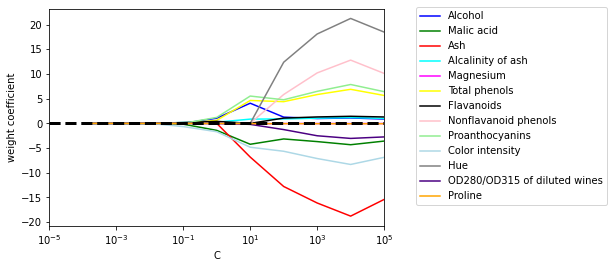

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

colors = ['blue', 'green', 'red', 'cyan',
          'magenta', 'yellow', 'black',
          'pink', 'lightgreen', 'lightblue',
          'gray', 'indigo', 'orange']

weights, params = [], []
for c in np.arange(-4., 6.):
    lr = LogisticRegression(solver='liblinear', multi_class='ovr', penalty='l1', C=10.**c, random_state=0)
    lr.fit(X_train, y_train)
    weights.append(lr.coef_[1])
    params.append(10**c)

weights = np.array(weights)

for column, color in zip(range(weights.shape[1]), colors):
    plt.plot(params, weights[:, column],
             label=df_wine.columns[column + 1],
             color=color)
plt.axhline(0, color='black', linestyle='--', linewidth=3)
plt.xlim([10**(-5), 10**5])
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.xscale('log')
plt.legend(loc='upper left')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.38, 1.03),
          ncol=1, fancybox=True)
#plt.savefig('L1_featureselection.png', dpi=300,
#            bbox_inches='tight', pad_inches=0.2)
plt.show()

## Sequential feature selection algorithms

An alternative way to reduce the complexity of the model and avoid overfitting is **dimensionality reduction** via feature selection, which is especially useful for unregularized models. Using feature selection, we select a subset of the original features. We will now look at a classic family of feature selection algowithms.

Sequential feature selection algorithms are a family of greedy search algorithms that are used to reduce an initial *d-dimensional* feature space to a *k-dimensional* feature subspace where k < d. The motivation behind feature selection algorithms is to automatically selecta subset of features that are most relevant to the problem to improve computational efficiency or reduce the generalization error of the model by removing irrelevant features or noise, which can be useful for algorithms that don't support regularization.

A classical geature selection algorithm is **Sequential Backward Elimination**, which aims to reduce the dimensionality of the initial feature subspace with a minimum decay in performance of the classifier to improve uupon computational efficiency. In certain cases, SBS can even improve the predictive power of the model if a model suffers from overfitting.

The idea behind the SBE algorithm is quite simple: SBE sequentially removes features from the full feature subset until the new feature subspace contains the desired number of features. In order to determine which feature is to be reomved at each stage, we need to define the criterion function $J$ that we want to minimize. The criterion calculated by the criterion function can simply be the difference in performance of the classifier after and before the removal of a particular feature. Then the feature to be removed at each stage can be defined as the feature that maximizes this criterion; or, in more intuitive terms, at each stage we eliminate the feature that causes the least performance loss after removal.

In [ ]:
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


class SBS():
    def __init__(self, estimator, k_features, scoring=accuracy_score,
                 test_size=0.25, random_state=1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y):

        X_train, X_test, y_train, y_test = \
            train_test_split(X, y, test_size=self.test_size,
                             random_state=self.random_state)

        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train,
                                 X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train,
                                         X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def transform(self, X):
        return X[:, self.indices_]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

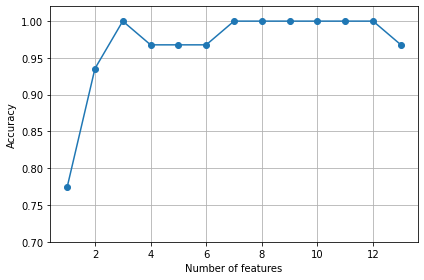

In [ ]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=5)

# selecting features
sbs = SBS(knn, k_features=1)
sbs.fit(X_train_std, y_train)

# plotting performance of feature subsets
k_feat = [len(k) for k in sbs.subsets_]

plt.plot(k_feat, sbs.scores_, marker='o')
plt.ylim([0.7, 1.02])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.grid()
plt.tight_layout()
# plt.savefig('feature_selection.png', dpi=300)
plt.show()

In [ ]:
k3 = list(sbs.subsets_[10]) # features selected at the 10th run of feature elimination.
print(df_wine.columns[1:][k3])

Index(['Alcohol', 'Malic acid', 'OD280/OD315 of diluted wines'], dtype='object')


In [ ]:
k4 = list(sbs.subsets_[9]) # features selected at the 9th run of feature elimination.
print(df_wine.columns[1:][k4])

Index(['Alcohol', 'Malic acid', 'Ash', 'OD280/OD315 of diluted wines'], dtype='object')


In [ ]:
knn.fit(X_train_std, y_train)
print('Training accuracy:', knn.score(X_train_std, y_train))
print('Test accuracy:', knn.score(X_test_std, y_test))

Training accuracy: 0.967741935483871
Test accuracy: 0.9629629629629629


In [ ]:
knn.fit(X_train_std[:, k3], y_train)
print('Training accuracy:', knn.score(X_train_std[:, k3], y_train))
print('Test accuracy:', knn.score(X_test_std[:, k3], y_test))

Training accuracy: 0.9516129032258065
Test accuracy: 0.9259259259259259


## Recursive feature elimination for estimators that assign weights

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features.That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston

boston = load_boston()
X = boston["data"]
Y = boston["target"]
names = boston["feature_names"]

#use linear regression as the model
lr = LinearRegression()
#rank all features, i.e continue the elimination until the last one
rfe = RFE(lr, n_features_to_select=1)
rfe.fit(X,Y)

print("Features sorted by their rank:")
print(sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names)))


Features sorted by their rank:
[(1, 'NOX'), (2, 'RM'), (3, 'CHAS'), (4, 'PTRATIO'), (5, 'DIS'), (6, 'LSTAT'), (7, 'RAD'), (8, 'CRIM'), (9, 'INDUS'), (10, 'ZN'), (11, 'TAX'), (12, 'B'), (13, 'AGE')]


# Handling text features

Another common need in feature engineering is to convert text to a set of representative
numerical values. For example, most automatic mining of social media data relies
on some form of encoding the text as numbers. One of the simplest methods of
encoding data is by word counts: you take each snippet of text, count the occurrences
of each word within it, and put the results in a table.
For example, consider the following set of three phrases:

In [ ]:
sample = ['problem of evil',
'evil queen',
'horizon problem']

For a vectorization of this data based on word count, we could construct a column
representing the word “problem,” the word “evil,” the word “horizon,” and so on.
While doing this by hand would be possible, we can avoid the tedium by using Scikit-
Learn’s CountVectorizer:

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
X = vec.fit_transform(sample)
print(X)

  (0, 3)	1
  (0, 2)	1
  (0, 0)	1
  (1, 0)	1
  (1, 4)	1
  (2, 3)	1
  (2, 1)	1


The result is a sparse matrix recording the number of times each word appears; it is
easier to inspect if we convert this to a DataFrame with labeled columns:

In [ ]:
import pandas as pd
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


There are some issues with this approach, however: the raw word counts lead to features
that put too much weight on words that appear very frequently, and this can be
suboptimal in some classification algorithms. One approach to fix this is known as
term frequency–inverse document frequency (TF–IDF), which weights the word counts
by a measure of how often they appear in the documents. The syntax for computing
these features is similar to the previous example:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer()
X = vec.fit_transform(sample)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,0.517856,0.000000,0.680919,0.517856,0.000000
1,0.605349,0.000000,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.000000,0.605349,0.000000


In [ ]:
vec = TfidfVectorizer(stop_words='english')
X = vec.fit_transform(sample)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,problem,queen
0,0.707107,0.000000,0.707107,0.000000
1,0.605349,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.605349,0.000000
